# Project Notebook
##### Created by Dario Sandrucci 48436

bla bla bla

### 0. Import Packages

In [1]:
from data_engineering import *
from denoising_and_detoning import *
from algorithm import *
from portfolio_and_backtesting import *

### 1. Data Preparation and Exploration

##### 1.1 Loading Data

Let import return data from S&P 500 stocks over the period of approximately the last 10 years.

In [2]:
tickers = getTickers()
end = dt.now()
start = dt.fromisoformat('2012-10-15')
df = getData(start, end, tickers, downloaded = True)

Data was loaded sucessfully!


##### 1.2 Data Visualization

A chart the shows the percentage returns over the period of the sample.

In [ ]:
ax = df.plot(legend=False, figsize=(20,10))
ax.set_ylabel('percentage returns')
ax.set_title('Log Returns of S&P500 Stocks for Training Period')

A chart to show the cummulative returns of the SPY index over the data period.

In [ ]:
spy_returns = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
spy_returns = spy_returns.pct_change().dropna(axis = 0)
spy_cum = np.cumprod(1 + spy_returns) - 1
spy_cum.columns = ["S&P 500 Index"]

ax = spy_cum.plot(legend=False, figsize=(8,5))
ax.set_ylabel('cumulative returns')
ax.set_title('Cummulative returns of the S&P 500 Index over the period of the data set')

##### 1.3 Data Transformation

We will split the set into train and test set.

In [3]:
train_set, test_set = testTrainSplit(df, validation_set = False, w_tt = [0.9, 0.1])

Now lets derive the empirical correlation matrix of our return data.

In [4]:
corr0 = pd.DataFrame(getCorrMatrix(train_set), index = train_set.columns, columns = train_set.columns )

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr0)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr0, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

### 2. Denoise and Detone the Empirical correlation Matrix

Lets denoise the correlation matrix.

In [5]:
eVal0, eVec0, eVal1, eVec1, corr1, var0 = denoiseMatrix(corr0)

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr1)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr1, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

Next lets detone the correlation matrix.

In [6]:
corr2 = detoneMatrix(corr1, eVal1, eVec1)

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr2)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr2, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

## 3. Distance Metrics

We will use the mikowski distance metric. Our denoised and detoned correlation matrix is transformed accordingly.

In [7]:
from sklearn.metrics import pairwise_distances

In [8]:
min_matrix = np.array(pairwise_distances(corr2, metric = "minkowski"))

## 3. Portfolio Construction

#### 3.1 Clustering

##### 3.1.1 Finding the number of clusters

Our first method is the Elbow method

In [ ]:
nr_clusters_sse = sse(min_matrix)

Now lets try the Silhouette method

In [ ]:
nr_clusters_sil = sil_score(min_matrix)

Our last method is the Davies-Boulding Score

In [ ]:
nr_clusters_db = db_score(min_matrix)

We will use the median number of clusters for for Kmeans.

##### 3.1.2 Running the clustering algorithm

In [12]:
w = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5)


Nested Clustering Algorithm 2.1.2

Processing input data....
Clustering algorithm in progress...


100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


Calculating inter cluster weights for cluster 1 of 3...


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


Calculating inter cluster weights for cluster 2 of 3...


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


Calculating inter cluster weights for cluster 3 of 3...


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


Calculating inter cluster weights...


100%|██████████| 50/50 [00:15<00:00,  3.31it/s]

Nested clustering algorithm completed sucessful!


## 4. Perfromance evaluation

#### 4.1. Benchmarking

##### 4.1.1 Clustering vs general portfolios

We will compare our clustering portfolio with a few other common portfolio types, the mean-variance optimized (MVP), risk-parity (RPP), and equal-weighted portfolio (EWP), as well as the S&P index itself (SPY).

First let calculated the portfolio weights:

In [ ]:
#Clustering
w_NCOMO = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5)
#EW
w_EW = np.ones(len(train_set.columns))
w_EW /= [len(train_set.columns)]*len(train_set.columns)
#MVO
w_MVO = optPortMVO()
#RPP
w_RPP = optPortRPP()

Not lets build the portfolios:

In [13]:
#building the single portfolios
port_NCOMO = Portfolio("NCO Minkowski Omega", test_set, w_NCOMO)
port_EWP = Portfolio("Equal Weighted", test_set, w_EW)
port_MVO = Portfolio("Mean Variance", test_set, w_NCOMO)
port_RPP = Portfolio("Risk Parity", test_set, w_NCOMO)
#comparing the portfolios


We are ready to perform some comparisons:

In [28]:
w_EW = np.ones(len(min_matrix))
w_EW /= [len(min_matrix)]*len(min_matrix)
ew = Portfolio("EW Port", test_set, w_EW)

In [29]:
BM = PortfolioBenchmarking([ncoMinkOmega, ew])

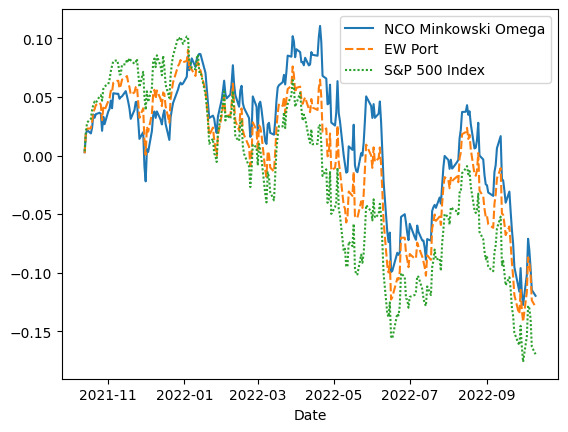

In [31]:
BM.plot_performance()